In [1]:
from utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
from plotting_utils import (
                get_validation_series,
                make_plots,
                make_crps_seq_plot,
                make_crps_strip_plot,
)
import os
import time
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

In [2]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

In [3]:
data_preprocessor.sites_dict.keys()

dict_keys(['BARC', 'BIGC', 'PRIN', 'MART', 'WLOU', 'POSE', 'BLUE', 'PRLA', 'GUIL', 'TOOK', 'MCRA', 'FLNT', 'CUPE', 'BLWA', 'TECR', 'PRPO', 'SYCA', 'BLDE', 'LECO', 'REDB', 'KING', 'SUGG', 'ARIK', 'MCDI', 'CARI', 'OKSR', 'COMO', 'CRAM', 'WALK', 'LEWI', 'LIRO', 'TOMB', 'MAYF', 'HOPB'])

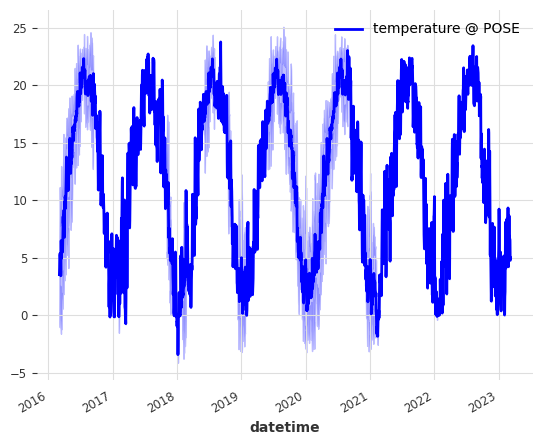

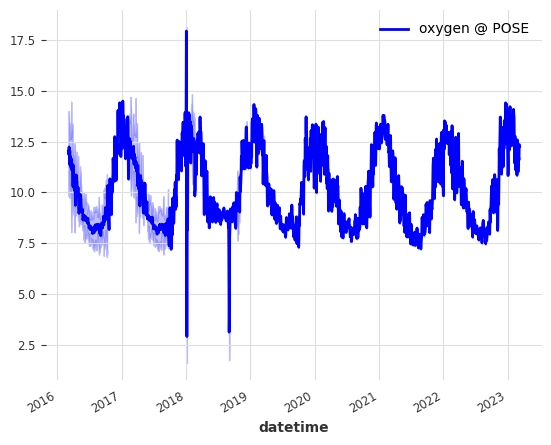

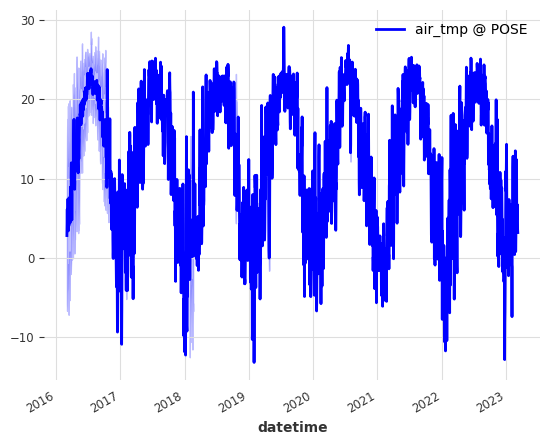

In [4]:
data_preprocessor.plot_by_site("POSE")

In [2]:
models = ["TFT"]
args = [models, targets, "POSE", "oxygen"]

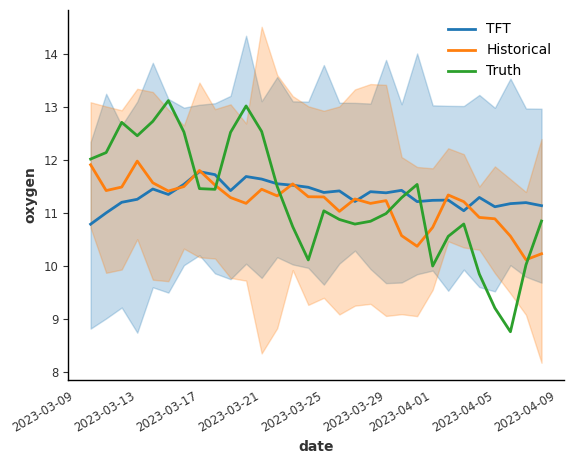

In [4]:
make_plots(*args)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


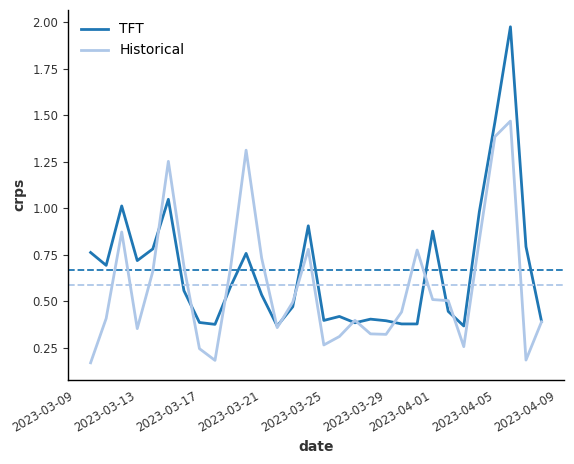

In [5]:
make_crps_seq_plot(*args)

Need to have an ability to save plots, also would be better to recreate the jitter plot used in previous forecasting paper

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


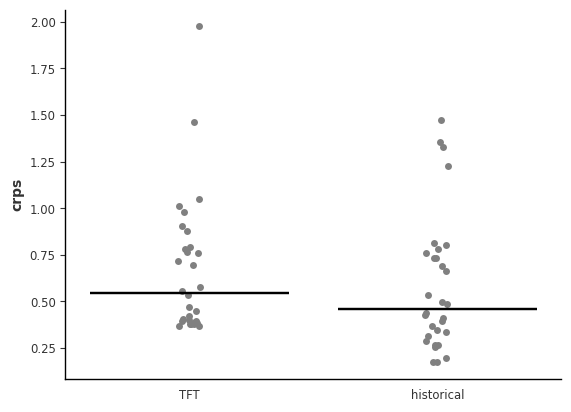

In [3]:
scores_dict = make_crps_strip_plot(*args)